import libs

In [13]:
import matplotlib.pyplot as plt
import scipy.signal as sp
import numpy as np
import pywt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

here we will read ECG. each line repesent a single heart beat. after each sample there is "|"

In [14]:
def get_values_from_line(line:str):
    values_str = line.split(sep="|")#return return list of float string values
    
    values =[]
    for i in range(len(values_str) - 1):#len(values_str) -1 because the end entry is "" or "\n"
        values.append(float(values_str[i]))

    return values
   

In [15]:
def get_ECG_data(filePath:str):
    dataFile = open(filePath,'r')
    data = [[]] #I do this to return data in right way

    for line in dataFile.readlines():
        values = get_values_from_line(line)#get samples of each heart beat 
        data.append(values)

    dataFile.close()
    return data[1:]# because first entery is [] we don't need it in the data

In [16]:
def bandpass_filter(data, lowcut = 0.5, highcut= 40.0, fs = 360, order = 4 ):
    # Design Butterworth bandpass filter
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = sp.butter(order, Wn=[low, high], btype='band')

    # Apply the filter
    filtered_data = sp.filtfilt(b, a, data)
    return filtered_data


In [17]:
def get_filtered_data(data, lowcut = 0.5, highcut= 40.0,fs = 360, order = 4):
    filtered_data = []
    for beat in data:
        filtered_data.append(bandpass_filter(data=beat, lowcut=lowcut, highcut=highcut, fs=fs,order=order))
    return filtered_data

In [18]:
def Normalize_Signal(data, check):
    """
    Normalize all sublists in the input data to the range [0, 1] or [-1, 1].

    :param data: A list of lists containing signal data.
    :param check: Integer flag. If 0, normalize to [0, 1]. If 1, normalize to [-1, 1].
    :return: A list of normalized sublists.
    """
    normalized_data = []

    for y in data:
        # Get min and max values in the sublist
        min_element = min(y)
        max_element = max(y)

        if min_element == max_element:
            raise ValueError("Normalization not possible: all values in a sublist are the same.")

        # Normalize based on the check parameter
        if check == 0:
            y_normalized = [(x - min_element) / (max_element - min_element) for x in y]
        else:
            y_normalized = [2 * (x - min_element) / (max_element - min_element) - 1 for x in y]

        normalized_data.append(y_normalized)

    return normalized_data

import our data from files

In [19]:
normal_train = get_ECG_data(r"Data\Normal&PVC\Normal_Train.txt")

print(len(normal_train))
print(normal_train[0])
print(normal_train[-1])
print(len(normal_train[40]))
print(len(normal_train[-1]))


200
[-0.050778, -0.050778, -0.040778, -0.035778, -0.045778, -0.055778, -0.065778, -0.045778, -0.050778, -0.040778, -0.025778, -0.055778, -0.070778, -0.050778, -0.035778, -0.020778, -0.025778, -0.030778, -0.035778, -0.065778, -0.030778, -0.035778, -0.035778, -0.035778, -0.035778, -0.035778, -0.025778, -0.025778, -0.030778, -0.030778, -0.025778, -0.010778, 0.004222, 0.004222, -0.005778, -0.010778, -0.010778, -0.00077803, 0.009222, 0.044222, 0.064222, 0.069222, 0.069222, 0.10922, 0.13922, 0.14422, 0.13422, 0.099222, 0.074222, 0.069222, 0.069222, 0.079222, 0.074222, 0.069222, 0.049222, 0.029222, 0.034222, 0.034222, 0.044222, 0.029222, 0.014222, 0.009222, -0.015778, -0.015778, -0.040778, -0.035778, -0.040778, -0.030778, -0.020778, -0.020778, -0.030778, -0.035778, -0.070778, -0.065778, -0.065778, -0.050778, -0.035778, -0.040778, -0.055778, -0.065778, -0.040778, -0.020778, -0.025778, -0.040778, -0.075778, -0.070778, -0.075778, -0.070778, -0.075778, -0.085778, 0.014222, 0.19922, 0.41922, 0.669

In [20]:
normal_test = get_ECG_data(r"Data\Normal&PVC\Normal_Test.txt")

print(len(normal_test))
print(normal_test[0])
print(normal_test[-1])


200
[-0.013701, -0.023701, -0.018701, -0.008701, -0.003701, 0.001299, 0.001299, -0.003701, 0.006299, 0.001299, 0.016299, 0.006299, 0.006299, 0.001299, 0.001299, 0.016299, 0.026299, 0.011299, 0.001299, -0.008701, 0.001299, 0.011299, 0.016299, 0.026299, 0.036299, 0.031299, 0.031299, 0.036299, 0.056299, 0.056299, 0.051299, 0.081299, 0.086299, 0.1013, 0.1063, 0.1013, 0.091299, 0.076299, 0.086299, 0.081299, 0.081299, 0.081299, 0.076299, 0.071299, 0.066299, 0.071299, 0.086299, 0.096299, 0.1013, 0.061299, 0.021299, 0.021299, 0.006299, -0.003701, -0.023701, -0.023701, -0.018701, -0.008701, -0.013701, -0.008701, -0.018701, -0.033701, -0.038701, -0.033701, -0.033701, -0.043701, -0.038701, -0.048701, -0.023701, -0.028701, -0.023701, -0.013701, -0.038701, -0.048701, -0.033701, -0.023701, -0.018701, -0.023701, -0.043701, -0.058701, -0.053701, -0.073701, -0.1187, -0.1387, -0.1687, -0.2037, -0.2287, -0.1987, -0.1087, 0.006299, 0.1463, 0.2913, 0.5413, 0.7963, 1.0263, 1.1813, 1.2463, 1.2113, 1.0613, 0.

In [21]:
pvc_test = get_ECG_data(r"Data\Normal&PVC\PVC_Test.txt")

print(len(pvc_test))
print(pvc_test[0])
print(pvc_test[-1])


200
[-0.24824, -0.21824, -0.20324, -0.22824, -0.23324, -0.23324, -0.23324, -0.20324, -0.18824, -0.19824, -0.20324, -0.21324, -0.18824, -0.17824, -0.17324, -0.17824, -0.20324, -0.17824, -0.17324, -0.17324, -0.16324, -0.15824, -0.16824, -0.17824, -0.16824, -0.14324, -0.13824, -0.13324, -0.13324, -0.14824, -0.13824, -0.11824, -0.083241, -0.088241, -0.10324, -0.098241, -0.10324, -0.083241, -0.078241, -0.073241, -0.078241, -0.078241, -0.078241, -0.073241, -0.068241, -0.073241, -0.088241, -0.093241, -0.088241, -0.073241, -0.078241, -0.083241, -0.083241, -0.088241, -0.10324, -0.088241, -0.078241, -0.093241, -0.098241, -0.098241, -0.093241, -0.088241, -0.078241, -0.10324, -0.10324, -0.098241, -0.093241, -0.073241, -0.073241, -0.078241, -0.083241, -0.078241, -0.088241, -0.068241, -0.073241, -0.073241, -0.093241, -0.088241, -0.093241, -0.088241, -0.073241, -0.073241, -0.078241, -0.073241, -0.033241, 0.011759, 0.011759, -0.083241, -0.26824, -0.46824, -0.60324, -0.67324, -0.72324, -0.74824, -0.778

In [22]:
pvc_train = get_ECG_data(r"Data\Normal&PVC\PVC_Train.txt")

print(len(pvc_train))
print(pvc_train[0])
print(pvc_train[-1])


200
[0.031147, 0.026147, 0.0061474, 0.0011474, 0.011147, 0.021147, 0.031147, 0.031147, 0.0011474, 0.0011474, -0.013853, 0.0011474, 0.011147, 0.021147, 0.021147, -0.0038526, -0.018853, -0.028853, -0.0088526, 0.0061474, 0.0011474, -0.013853, -0.048853, -0.028853, -0.018853, 0.0011474, -0.0088526, -0.023853, -0.018853, -0.0038526, -0.0038526, 0.0061474, -0.023853, -0.028853, -0.028853, -0.013853, -0.0038526, -0.0038526, -0.023853, -0.033853, -0.033853, -0.0038526, 0.016147, 0.016147, 0.011147, -0.023853, -0.033853, -0.023853, -0.018853, -0.0088526, 0.0061474, -0.0088526, -0.018853, -0.018853, 0.0011474, 0.016147, 0.0011474, -0.0038526, -0.018853, -0.0088526, -0.018853, 0.0011474, -0.013853, -0.013853, -0.0038526, 0.0061474, 0.011147, 0.031147, 0.021147, 0.011147, 0.031147, 0.051147, 0.056147, 0.071147, 0.086147, 0.10115, 0.11115, 0.13615, 0.17115, 0.21615, 0.24615, 0.26115, 0.31115, 0.38615, 0.49615, 0.58615, 0.69615, 0.74115, 0.77115, 0.82615, 0.90115, 0.94615, 1.0111, 1.0511, 1.0911, 1.

plot data before the filter

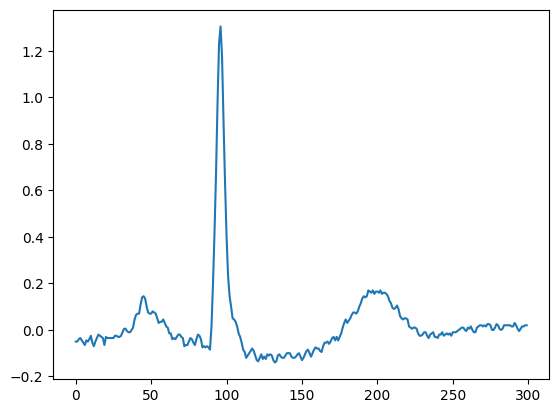

In [23]:
plt.plot(normal_train[0])

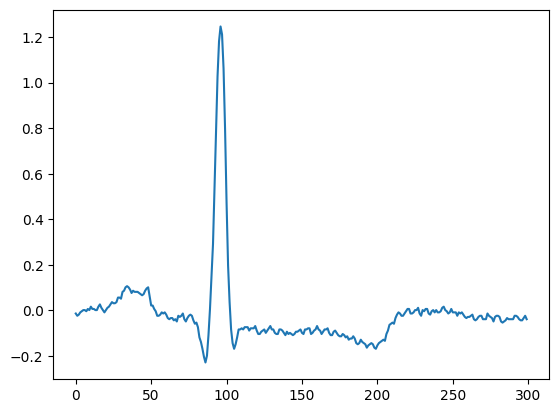

In [24]:
plt.plot(normal_test[0])

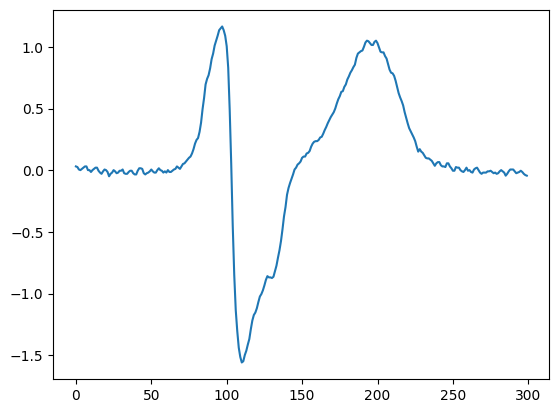

In [25]:
plt.plot(pvc_train[0])

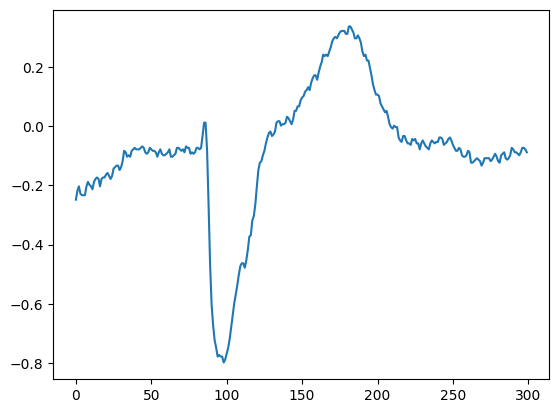

In [26]:
plt.plot(pvc_test[0])

apply bandpass filter on the data

In [27]:
normal_train_filtered = get_filtered_data(normal_train)
normal_test_filtered = get_filtered_data(normal_test)
pvc_train_filtered = get_filtered_data(pvc_train)
pvc_test_filtered = get_filtered_data(pvc_test)

plot after bandpass filter

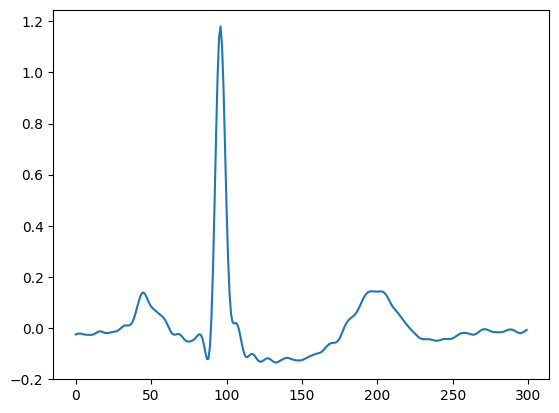

In [28]:
plt.plot(normal_train_filtered[0])

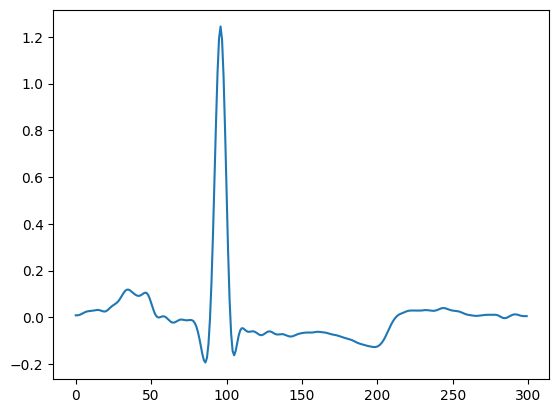

In [29]:
plt.plot(normal_test_filtered[0])

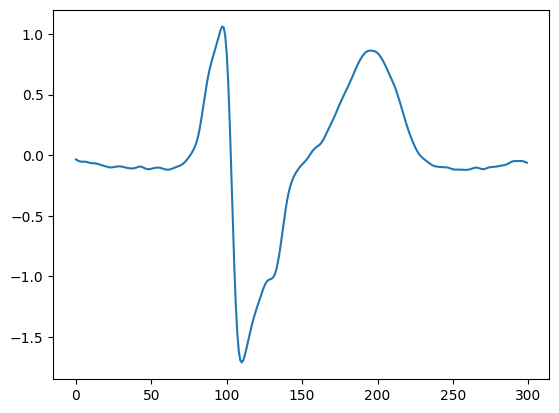

In [30]:
plt.plot(pvc_train_filtered[0])

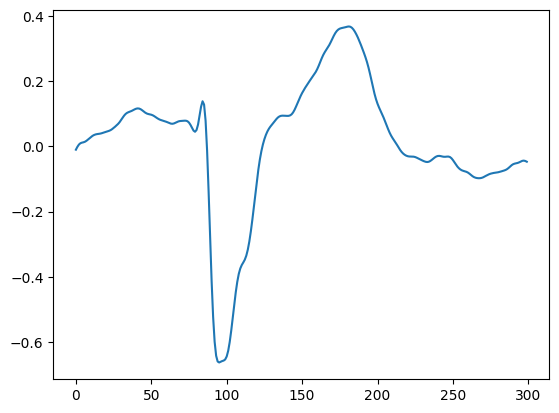

In [31]:
plt.plot(pvc_test_filtered[0])

apply normalize the data

In [32]:
normal_train_filtered_nor = Normalize_Signal(normal_train_filtered, check=1)  # Use check=1 for [-1, 1] normalization
normal_test_filtered_nor = Normalize_Signal(normal_test_filtered, check=1)  # Use check=1 for [-1, 1] normalization
pvc_train_filtered_nor = Normalize_Signal(pvc_train_filtered, check=1)  # Use check=1 for [-1, 1] normalization
pvc_test_filtered_nor = Normalize_Signal(pvc_test_filtered, check=1)  # Use check=1 for [-1, 1] normalization


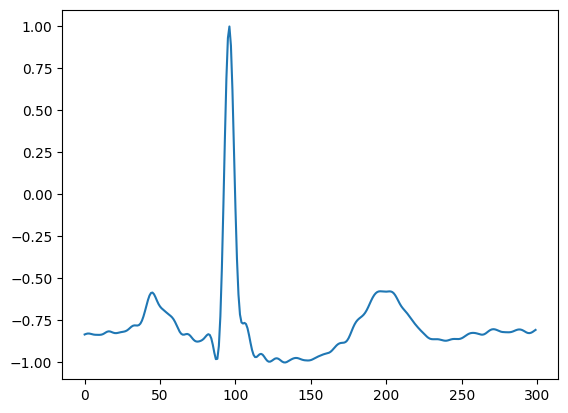

In [33]:
plt.plot(normal_train_filtered_nor[0])

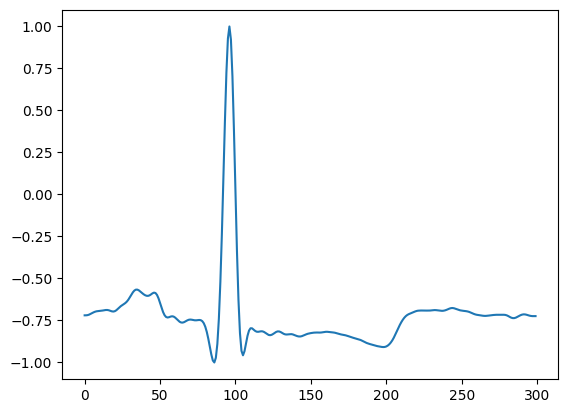

In [34]:
plt.plot(normal_test_filtered_nor[0])

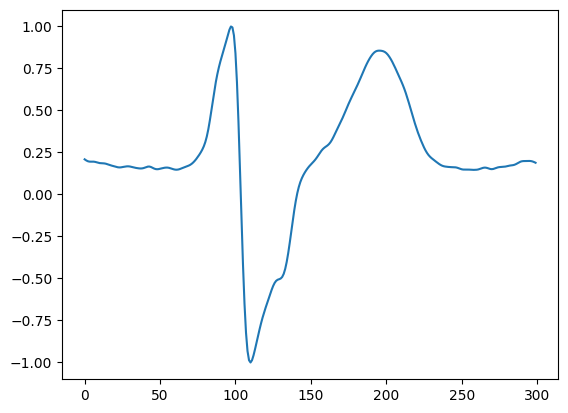

In [35]:
plt.plot(pvc_train_filtered_nor[0])

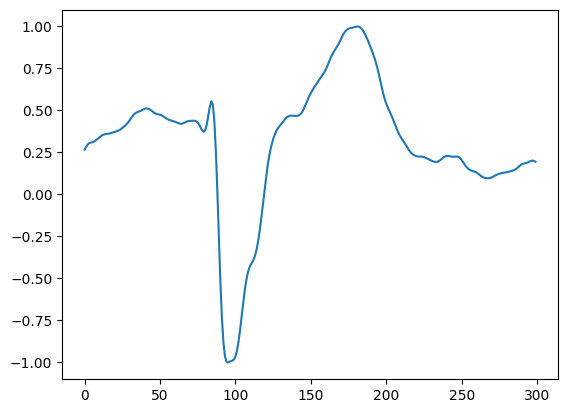

In [36]:
plt.plot(pvc_test_filtered_nor[0])

In [37]:
def wavelet_features(signal):
    coeffs = pywt.wavedec(signal, wavelet='db4', level=4)
    wavelets = []
    for coeff in coeffs:
        wavelets.append(np.mean(coeff))
        wavelets.append(np.std(coeff))
        wavelets.append(np.sum(np.square(coeff)))
        wavelets.append(np.max(coeff))
        wavelets.append(np.min(coeff))
        wavelets.append(np.max(coeff) - np.min(coeff))
    return np.array(wavelets)

In [38]:
def features_data(data):
    features = []
    for signal in data:
        features.append(wavelet_features(signal))
    return np.array(features)

In [39]:
train_data = np.concatenate((normal_train_filtered_nor, pvc_train_filtered_nor))
train_labels = np.array([0] * len(normal_train_filtered_nor) + [1] * len(pvc_train_filtered_nor))

In [40]:
test_data = np.concatenate((normal_test_filtered_nor, pvc_test_filtered_nor))
test_labels = np.array([0] * len(normal_test_filtered_nor) + [1] * len(pvc_test_filtered_nor))

In [41]:
train_data, train_labels = shuffle(train_data, train_labels, random_state=46)
test_data, test_labels = shuffle(test_data, test_labels, random_state=46)

In [42]:
features_train = features_data(train_data)
features_test = features_data(test_data)

In [43]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [ ]:
k_range = range(1, 31)

cv_scores = []

for k in k_range:
    knn_test = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_test, features_train, train_labels, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

best_k = k_range[np.argmax(cv_scores)]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(features_train, train_labels)

KNeighborsClassifier(n_neighbors=2)

In [48]:
prediction = knn.predict(features_test)
print(accuracy_score(test_labels, prediction))
print( prediction)

0.995
[1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1
 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1
 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 1
 0 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1
 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0
 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1
 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1
 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1
 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 0
 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0]


In [46]:
knn_scores = cross_val_score(knn, features_train, train_labels, cv=10)
print("Cross-validation scores:\n", knn_scores)
print("Average Cross-Validation score: {:.3f}".format(knn_scores.mean()))

Cross-validation scores:
 [1.   1.   1.   1.   1.   1.   1.   1.   1.   0.95]
Average Cross-Validation score: 0.995


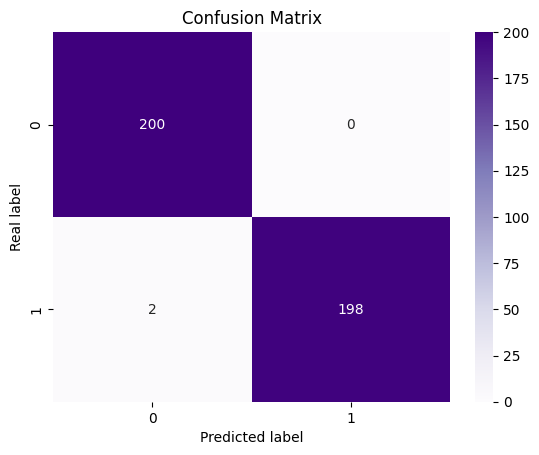

In [47]:
confusion_mat= confusion_matrix(test_labels,prediction)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted label")
plt.ylabel("Real label")
plt.title("Confusion Matrix")
plt.show()